BAGIAN 1: Introduction & Dataset Overview

######Dataset yang digunakan dalam penelitian ini adalah Default of Credit Card Clients (Taiwan) yang berisi data sebanyak 30.000 klien kartu kredit dengan total 24 fitur input dan 1 target variable. Target yang diprediksi adalah default.payment.next.month, yaitu variabel biner yang menunjukkan apakah nasabah akan melakukan gagal bayar pada bulan berikutnya (0 = Non-default, 1 = Default). Distribusi kelas pada dataset ini tidak seimbang, dengan 23.364 data (77,88%) berada pada kelas non-default dan 6.636 data (22,12%) berada pada kelas default. Ketidakseimbangan ini menjadi perhatian khusus karena dapat mempengaruhi performa model dalam mendeteksi kelas minoritas. Fitur-fitur dalam dataset terbagi menjadi beberapa kelompok, yaitu demographic features (SEX, EDUCATION, MARRIAGE, AGE, LIMIT_BAL), payment status features (PAY_0 hingga PAY_6), bill amount features (BILL_AMT1 hingga BILL_AMT6), serta payment amount features (PAY_AMT1 hingga PAY_AMT6). Struktur fitur yang beragam ini memungkinkan analisis mendalam terhadap perilaku pembayaran nasabah dalam memprediksi risiko gagal bayar.

BAGIAN 1: INSTALL & IMPORT LIBRARIES

In [15]:
!pip install imbalanced-learn scikit-learn pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
f1_score, confusion_matrix, classification_report,
roc_auc_score, roc_curve, auc)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
import pickle
import warnings
warnings.filterwarnings('ignore')

Set plotting style

In [16]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

BAGIAN 2: DATA LOADING AND INITIAL EXPLORATION

In [21]:
#Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/friskaa28/Tugas-Besar--AKTF-Friska-Andalusia/master/dataset/default%20of%20credit%20card%20clients.csv')

In [22]:
#Display basic information
print(f"\n✓ Dataset Shape: {data.shape}")
print(f"✓ Total Records: {data.shape}")
print(f"✓ Total Features: {data.shape}")
print(f"\n✓ First 5 rows:")
print(data.head())

print(f"\n✓ Data Types:")
print(data.dtypes)

print(f"\n✓ Missing Values:")
print(data.isnull().sum().sum())


✓ Dataset Shape: (30000, 25)
✓ Total Records: (30000, 25)
✓ Total Features: (30000, 25)

✓ First 5 rows:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36

DATA CLEANING

In [23]:
#1. Rename PAY_0 to PAY_1 for consistency
data.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)

In [24]:
#2. Remove undocumented categories in EDUCATION
print(f"\n✓ EDUCATION value counts before cleaning:")
print(data['EDUCATION'].value_counts().sort_index())
undocumented_education = data[data['EDUCATION'].isin([0, 5, 6])].shape
data = data[~data['EDUCATION'].isin([0, 5, 6])]
print(f" → Removed {undocumented_education} rows with undocumented education")


✓ EDUCATION value counts before cleaning:
EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64
 → Removed (345, 25) rows with undocumented education


In [25]:
#3. Remove undocumented categories in MARRIAGE
print(f"\n✓ MARRIAGE value counts before cleaning:")
print(data['MARRIAGE'].value_counts().sort_index())
undocumented_marriage = data[data['MARRIAGE'] == 0].shape
data = data[data['MARRIAGE'] != 0]
print(f" → Removed {undocumented_marriage} rows with undocumented marriage status")


✓ MARRIAGE value counts before cleaning:
MARRIAGE
0       54
1    13477
2    15806
3      318
Name: count, dtype: int64
 → Removed (54, 25) rows with undocumented marriage status


In [28]:
#4. Fix PAY_n encoding
pay_columns = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in pay_columns:
    data[col] = data[col].apply(lambda x: 0 if x in [-1, 0] else x + 1)

print(f"\n✓ After cleaning - Dataset shape: {data.shape}")
print(f"✓ Total rows removed: {30000 - data.shape[0]}")


✓ After cleaning - Dataset shape: (29601, 25)
✓ Total rows removed: 399


BAGIAN 3: STATISTICAL SUMMARY OF DATASET

In [29]:
print(f"\n✓ Descriptive Statistics:")
print(data.describe())


✓ Descriptive Statistics:
             ID   LIMIT_BAL       SEX  EDUCATION  MARRIAGE       AGE  \
count  29601.00    29601.00  29601.00   29601.00  29601.00  29601.00   
mean   14971.76   167550.54      1.60       1.82      1.56     35.46   
std     8660.18   129944.02      0.49       0.71      0.52      9.21   
min        1.00    10000.00      1.00       1.00      1.00     21.00   
25%     7474.00    50000.00      1.00       1.00      1.00     28.00   
50%    14953.00   140000.00      2.00       2.00      2.00     34.00   
75%    22463.00   240000.00      2.00       2.00      2.00     41.00   
max    30000.00  1000000.00      2.00       4.00      3.00     79.00   

          PAY_1     PAY_2     PAY_3     PAY_4  ...  BILL_AMT4  BILL_AMT5  \
count  29601.00  29601.00  29601.00  29601.00  ...   29601.00   29601.00   
mean       0.82      0.62      0.59      0.50  ...   43122.55   40235.55   
std        1.55      1.50      1.47      1.39  ...   64196.38   60699.34   
min        0.00     

In [30]:
#Demographic Features Summary
print(f"\n✓ Demographic Features Summary:")
print(data[['AGE', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']].describe())


✓ Demographic Features Summary:
            AGE   LIMIT_BAL       SEX  EDUCATION  MARRIAGE
count  29601.00    29601.00  29601.00   29601.00  29601.00
mean      35.46   167550.54      1.60       1.82      1.56
std        9.21   129944.02      0.49       0.71      0.52
min       21.00    10000.00      1.00       1.00      1.00
25%       28.00    50000.00      1.00       1.00      1.00
50%       34.00   140000.00      2.00       2.00      2.00
75%       41.00   240000.00      2.00       2.00      2.00
max       79.00  1000000.00      2.00       4.00      3.00


In [31]:
#Payment Status Distribution
print(f"\n✓ Payment Status Distribution (PAY_1):")
print(data['PAY_1'].value_counts().sort_index())


✓ Payment Status Distribution (PAY_1):
PAY_1
0     22840
3      3662
4      2640
5       320
6        76
7        24
8        11
9         9
10       19
Name: count, dtype: int64


In [32]:
#Target Variable
print(f"\n✓ Target Variable Distribution:")
print(data['default.payment.next.month'].value_counts())
print(f"\n✓ Target Variable Percentage:")
print(data['default.payment.next.month'].value_counts(normalize=True) * 100)


✓ Target Variable Distribution:
default.payment.next.month
0    22996
1     6605
Name: count, dtype: int64

✓ Target Variable Percentage:
default.payment.next.month
0    77.69
1    22.31
Name: proportion, dtype: float64


In [33]:
#Correlation Analysis (Top 10)
print(f"\n✓ Top 10 Correlated Features with Default:")
correlation = data.corr()['default.payment.next.month'].sort_values(ascending=False)
print(correlation.head(11)[1:])


✓ Top 10 Correlated Features with Default:
PAY_1        3.97e-01
PAY_2        3.37e-01
PAY_3        2.94e-01
PAY_4        2.77e-01
PAY_5        2.69e-01
PAY_6        2.49e-01
EDUCATION    4.91e-02
AGE          1.44e-02
BILL_AMT6   -5.34e-03
BILL_AMT5   -6.23e-03
Name: default.payment.next.month, dtype: float64


BAGIAN 4: DATASET PREPARATION


4.1 CLASS IMBALANCE ANALYSIS:
 Class 0 (Non-Default): 22996 (77.69%)
 Class 1 (Default): 6605 (22.31%)
 Imbalance Ratio: 3.48:1


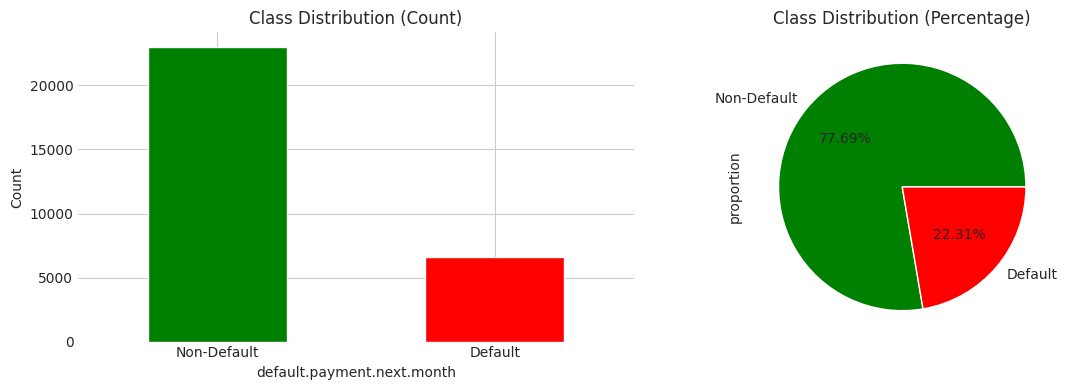

In [37]:
#4.1 Check Class Balance
print(f"\n4.1 CLASS IMBALANCE ANALYSIS:")
class_counts = data['default.payment.next.month'].value_counts()
class_pct = data['default.payment.next.month'].value_counts(normalize=True) * 100

# Extract scalar values from Series for correct formatting
non_default_count = class_counts[0]
default_count = class_counts[1]
non_default_pct = class_pct[0]
default_pct = class_pct[1]

print(f" Class 0 (Non-Default): {non_default_count} ({non_default_pct:.2f}%)")
print(f" Class 1 (Default): {default_count} ({default_pct:.2f}%)")

# Calculate imbalance ratio (majority class / minority class)
imbalance_ratio = non_default_count / default_count
print(f" Imbalance Ratio: {imbalance_ratio:.2f}:1")

#Visualisasi class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
data['default.payment.next.month'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Class Distribution (Count)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Default', 'Default'], rotation=0)

data['default.payment.next.month'].value_counts(normalize=True).plot(kind='pie', ax=axes[1],
labels=['Non-Default', 'Default'],
colors=['green', 'red'],
autopct='%1.2f%%')
axes[1].set_title('Class Distribution (Percentage)')
plt.tight_layout()
plt.show()

In [49]:
#4.2 Feature Engineering
print(f"\n4.2 FEATURE ENGINEERING:")
data['Payment_Delay_Avg'] = data[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)

# Calculate Bill_to_Limit_Ratio safely
denom_limit = data['LIMIT_BAL'] + 1
data['Bill_to_Limit_Ratio'] = np.where(denom_limit == 0, 0, data['BILL_AMT1'] / denom_limit)

# Calculate Payment_to_Bill_Ratio safely
denom_bill = data['BILL_AMT1'] + 1
data['Payment_to_Bill_Ratio'] = np.where(denom_bill == 0, 0, data['PAY_AMT1'] / denom_bill)

data['Average_Bill'] = data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
data['Average_Payment'] = data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
print(f" ✓ Created 5 new features from domain knowledge")


4.2 FEATURE ENGINEERING:
 ✓ Created 5 new features from domain knowledge


In [51]:
#4.3 Prepare features and target
print(f"\n4.3 TRAIN-TEST SPLIT (70:30):")
X = data.drop(['ID', 'default.payment.next.month'], axis=1)
y = data['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(
X, y,
test_size=0.30,
random_state=42,
stratify=y
)

print(f" ✓ Training Set Size: {X_train.shape} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f" ✓ Testing Set Size: {X_test.shape} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n ✓ Training Set Class Distribution:")
print(f" - Class 0: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f" - Class 1: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"\n ✓ Testing Set Class Distribution:")
print(f" - Class 0: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f" - Class 1: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")


4.3 TRAIN-TEST SPLIT (70:30):
 ✓ Training Set Size: (20720, 28) samples (70.0%)
 ✓ Testing Set Size: (8881, 28) samples (30.0%)

 ✓ Training Set Class Distribution:
 - Class 0: 16097 (77.7%)
 - Class 1: 4623 (22.3%)

 ✓ Testing Set Class Distribution:
 - Class 0: 6899 (77.7%)
 - Class 1: 1982 (22.3%)


In [52]:
#4.4 Feature Scaling
print(f"\n4.4 FEATURE SCALING:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f" ✓ StandardScaler applied to both train and test sets")
print(f" ✓ Scaling parameters from training set applied to test set (preventing data leakage)")


4.4 FEATURE SCALING:
 ✓ StandardScaler applied to both train and test sets
 ✓ Scaling parameters from training set applied to test set (preventing data leakage)


In [48]:
print(f"\nChecking X_train for infinite or very large values before scaling:")
# Check for infinite values
inf_check = X_train.isin([np.inf, -np.inf]).sum()
if inf_check.sum() > 0:
    print("\n⚠️  Infinite values detected in the following columns of X_train:")
    print(inf_check[inf_check > 0])
else:
    print("\n✓ No infinite values detected in X_train.")

# Check for values that might be too large for float64 (e.g., beyond typical machine epsilon limits for scaling)
# We'll use an arbitrary large number for this check, e.g., 1e18, but StandardScaler's limit could be more nuanced.
# A more direct approach is to check if any value exceeds the max float64 representation, but the error message
# implies the StandardScaler itself is having trouble with the magnitude, not just the raw numpy limit.

# Let's check for any extremely large numbers that might cause issues.
# The max value a float64 can hold is ~1.8e308. If we have values much smaller but still large enough
# to cause precision issues during scaling, it could trigger this. A common sign is if the range is enormous.

# For simplicity and given the context of previous error being actual 'inf', we'll rely on the inf check.
# However, if 'too large' is the actual problem for finite numbers, we'd need to inspect max() values per column.
# For now, let's just inspect max values if no inf detected, or if the inf check isn't the whole story.

max_values = X_train.max()
if (max_values > 1e18).any(): # Check for values that are genuinely very large, though not 'inf'
    print("\n⚠️  Extremely large finite values detected in the following columns of X_train:")
    print(max_values[max_values > 1e18])
else:
    print("\n✓ No extremely large finite values detected in X_train (values > 1e18).")

# Re-check for NaN values, as fillna might not have caught all cases if np.inf was present initially
nan_check = X_train.isnull().sum()
if nan_check.sum() > 0:
    print("\n⚠️  NaN values detected in the following columns of X_train:")
    print(nan_check[nan_check > 0])
else:
    print("\n✓ No NaN values detected in X_train.")


Checking X_train for infinite or very large values before scaling:

⚠️  Infinite values detected in the following columns of X_train:
Payment_to_Bill_Ratio    7
dtype: int64

⚠️  Extremely large finite values detected in the following columns of X_train:
Payment_to_Bill_Ratio    inf
dtype: float64

⚠️  NaN values detected in the following columns of X_train:
Payment_to_Bill_Ratio    4
dtype: int64


BAGIAN 5: BASELINE MODELING & EVALUATION

In [53]:
#Dictionary to store results
baseline_results = {}

In [55]:
# MODEL 1: Logistic Regression
print(f"\n5.1 LOGISTIC REGRESSION (Baseline):")
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

baseline_results['Logistic Regression'] = {
'Accuracy': acc_lr, 'Precision': prec_lr, 'Recall': rec_lr,
'F1-Score': f1_lr, 'ROC-AUC': auc_lr, 'y_pred': y_pred_lr, 'y_pred_proba': y_pred_proba_lr
}

print(f" Accuracy: {acc_lr:.4f}")
print(f" Precision: {prec_lr:.4f}")
print(f" Recall: {rec_lr:.4f}")
print(f" F1-Score: {f1_lr:.4f}")
print(f" ROC-AUC: {auc_lr:.4f}")


5.1 LOGISTIC REGRESSION (Baseline):
 Accuracy: 0.7718
 Precision: 0.4901
 Recall: 0.5626
 F1-Score: 0.5238
 ROC-AUC: 0.7513


In [57]:
# MODEL 2: Random Forest
print(f"\n5.2 RANDOM FOREST (Baseline):")
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42,
class_weight='balanced', n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

baseline_results['Random Forest'] = {
'Accuracy': acc_rf, 'Precision': prec_rf, 'Recall': rec_rf,
'F1-Score': f1_rf, 'ROC-AUC': auc_rf, 'y_pred': y_pred_rf, 'y_pred_proba': y_pred_proba_rf
}

print(f" Accuracy: {acc_rf:.4f}")
print(f" Precision: {prec_rf:.4f}")
print(f" Recall: {rec_rf:.4f}")
print(f" F1-Score: {f1_rf:.4f}")
print(f" ROC-AUC: {auc_rf:.4f}")


5.2 RANDOM FOREST (Baseline):
 Accuracy: 0.8024
 Precision: 0.5691
 Recall: 0.4717
 F1-Score: 0.5159
 ROC-AUC: 0.7657


In [59]:
# MODEL 3: Gradient Boosting
print(f"\n5.3 GRADIENT BOOSTING (Baseline):")
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
y_pred_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb)
rec_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

baseline_results['Gradient Boosting'] = {
'Accuracy': acc_gb, 'Precision': prec_gb, 'Recall': rec_gb,
'F1-Score': f1_gb, 'ROC-AUC': auc_gb, 'y_pred': y_pred_gb, 'y_pred_proba': y_pred_proba_gb
}

print(f" Accuracy: {acc_gb:.4f}")
print(f" Precision: {prec_gb:.4f}")
print(f" Recall: {rec_gb:.4f}")
print(f" F1-Score: {f1_gb:.4f}")
print(f" ROC-AUC: {auc_gb:.4f}")


5.3 GRADIENT BOOSTING (Baseline):
 Accuracy: 0.8200
 Precision: 0.6775
 Recall: 0.3688
 F1-Score: 0.4776
 ROC-AUC: 0.7794
